<a href="https://colab.research.google.com/github/divinelof/21120404_dissertation/blob/main/NB2_EcommerceFeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.impute import SimpleImputer

# **Data Loading**

In [ ]:
data_path = '/content/drive/MyDrive/EcommerceFraudDetection/'

train = pd.read_csv(f"{data_path}Train.csv")

print(train.shape)
print(f'{train.memory_usage(index=True, deep=True).sum():,}')
train.head()

(472432, 131)
692,956,255


,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V317,isFraud,ProductCD,card4,card6,P_emaildomain,M2,M3,M4,M6
0,54.500,585018.0,1974.0,111.0,150.0,226.0,184.0,87.0,1.0,1.0,...,50.0,0.0,W,visa,debit,gmail.com,T,T,M0,F
1,49.000,6190560.0,3484.0,372.0,150.0,117.0,264.0,87.0,1.0,2.0,...,0.0,0.0,W,mastercard,debit,gmail.com,T,T,M0,T
2,76.125,8742212.0,9300.0,103.0,185.0,138.0,299.0,87.0,1.0,1.0,...,0.0,0.0,C,visa,debit,gmail.com,T,T,M0,F
3,323.000,4736959.0,7638.0,174.0,150.0,166.0,123.0,87.0,1.0,1.0,...,0.0,0.0,W,visa,debit,gmail.com,T,T,M0,F
4,34.000,15802614.0,17926.0,124.0,150.0,226.0,269.0,87.0,2.0,1.0,...,0.0,0.0,W,visa,debit,yahoo.com,T,T,M1,F


In [ ]:
validation = pd.read_csv(f"{data_path}Validation.csv")

print(validation.shape)
print(f'{validation.memory_usage(index=True, deep=True).sum():,}')
validation.head()

(118108, 131)
173,241,358


,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V317,isFraud,ProductCD,card4,card6,P_emaildomain,M2,M3,M4,M6
0,29.546875,4655781.0,6107.0,467.0,150.0,226.0,158.0,87.0,4.0,2.0,...,0.000000,0.0,W,visa,debit,gmail.com,T,T,M0,F
1,57.937500,5407987.0,1675.0,174.0,150.0,226.0,330.0,87.0,165.0,151.0,...,107.949997,0.0,W,visa,debit,gmail.com,T,T,M0,F
2,70.000000,6314603.0,16075.0,514.0,150.0,102.0,330.0,87.0,1.0,1.0,...,70.000000,0.0,H,mastercard,credit,gmail.com,T,T,M0,F
3,59.000000,9740016.0,15063.0,514.0,150.0,226.0,181.0,87.0,3.0,2.0,...,0.000000,0.0,W,visa,credit,comcast.net,T,T,M1,F
4,100.000000,1108426.0,12156.0,555.0,117.0,224.0,296.0,32.0,1.0,1.0,...,0.000000,0.0,H,mastercard,credit,anonymous.com,T,T,M0,F


# **Feature Engineering**

In [ ]:
def log_trans(df, new_columns=[]):
    df['LogTransactionAmt'] = np.log1p(df['TransactionAmt'])
    new_columns += ['LogTransactionAmt']
    return df

In [ ]:
def add_misc_features(df, new_columns=[]):
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')


    df['P_emaildomain_1'] = df['P_emaildomain'].str.split('.', expand=True)[0]

    
    new_columns += ['TransactionAmt_to_mean_card1', 'TransactionAmt_to_mean_card4', 'P_emaildomain_1']
    return df

In [ ]:
def add_uid_features(df, new_columns=[]): 
    df['uid1'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid2'] = df['uid1'].astype(str) + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    new_columns += ['uid1', 'uid2', 'uid3']
    return df

In [ ]:
def add_time_features_1(df, new_columns=[]):
    df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
    df['Transaction_hour_of_day'] = np.floor(df['TransactionDT'] / 3600) % 24
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    new_columns += ['Transaction_day_of_week', 'Transaction_hour_of_day', 'TransactionAmt_decimal']
    return df

In [ ]:
import datetime
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

def add_time_features_2(df, new_columns=[]):
    # Temporary variables for aggregation
    START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
        
    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
    new_columns += ['DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'is_december', 'is_holiday']
    return df

In [ ]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

def add_domain_1(df, new_columns=[]):
    for c in ['P_emaildomain']:
        df[c + '_bin'] = df[c].map(emails)
        df[c + '_suffix'] = df[c].map(lambda x: str(x).split('.')[-1])
        df[c + '_suffix'] = df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

    new_columns += ['P_emaildomain_bin', 'P_emaildomain_suffix']

    return df

In [ ]:
def add_new_features(df):
    new_features = []
    df = log_trans(df, new_features)
    df = add_misc_features(df, new_features)
    df = add_uid_features(df, new_features)
    df = add_time_features_1(df, new_features)
    df = add_domain_1(df, new_features)

    return df, new_features

newTrain, newFeatures = add_new_features(train)
print(len(newFeatures))

newValidation, _ = add_new_features(validation)

12


In [ ]:
train.shape, validation.shape

((472432, 143), (118108, 143))

In [ ]:
newTrain.head()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,TransactionAmt_to_mean_card4,P_emaildomain_1,uid1,uid2,uid3,Transaction_day_of_week,Transaction_hour_of_day,TransactionAmt_decimal,P_emaildomain_bin,P_emaildomain_suffix
0,54.500,585018.0,1974.0,111.0,150.0,226.0,184.0,87.0,1.0,1.0,...,0.409149,gmail,1974.0_111.0,1974.0_111.0_150.0_226.0,1974.0_111.0_150.0_226.0_184.0_87.0,5.0,18.0,500,google,com
1,49.000,6190560.0,3484.0,372.0,150.0,117.0,264.0,87.0,1.0,2.0,...,0.371196,gmail,3484.0_372.0,3484.0_372.0_150.0_117.0,3484.0_372.0_150.0_117.0_264.0_87.0,0.0,15.0,0,google,com
2,76.125,8742212.0,9300.0,103.0,185.0,138.0,299.0,87.0,1.0,1.0,...,0.571495,gmail,9300.0_103.0,9300.0_103.0_185.0_138.0,9300.0_103.0_185.0_138.0_299.0_87.0,2.0,4.0,125,google,com
3,323.000,4736959.0,7638.0,174.0,150.0,166.0,123.0,87.0,1.0,1.0,...,2.424867,gmail,7638.0_174.0,7638.0_174.0_150.0_166.0,7638.0_174.0_150.0_166.0_123.0_87.0,4.0,19.0,0,google,com
4,34.000,15802614.0,17926.0,124.0,150.0,226.0,269.0,87.0,2.0,1.0,...,0.255249,yahoo,17926.0_124.0,17926.0_124.0_150.0_226.0,17926.0_124.0_150.0_226.0_269.0_87.0,6.0,21.0,0,yahoo,com


In [ ]:
newValidation.head()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,uid2,uid3,Transaction_day_of_week,Transaction_hour_of_day,TransactionAmt_decimal,P_emaildomain_bin,P_emaildomain_suffix,clusterFeature1,clusterFeature2,clusterFeature3
0,29.546875,4655781.0,6107.0,467.0,150.0,226.0,158.0,87.0,4.0,2.0,...,6107.0_467.0_150.0_226.0,6107.0_467.0_150.0_226.0_158.0_87.0,3.0,21.0,546,google,com,1,1,2
1,57.937500,5407987.0,1675.0,174.0,150.0,226.0,330.0,87.0,165.0,151.0,...,1675.0_174.0_150.0_226.0,1675.0_174.0_150.0_226.0_330.0_87.0,5.0,14.0,937,google,com,2,3,2
2,70.000000,6314603.0,16075.0,514.0,150.0,102.0,330.0,87.0,1.0,1.0,...,16075.0_514.0_150.0_102.0,16075.0_514.0_150.0_102.0_330.0_87.0,2.0,2.0,0,google,com,0,0,3
3,59.000000,9740016.0,15063.0,514.0,150.0,226.0,181.0,87.0,3.0,2.0,...,15063.0_514.0_150.0_226.0,15063.0_514.0_150.0_226.0_181.0_87.0,6.0,17.0,0,other,us,0,1,1
4,100.000000,1108426.0,12156.0,555.0,117.0,224.0,296.0,32.0,1.0,1.0,...,12156.0_555.0_117.0_224.0,12156.0_555.0_117.0_224.0_296.0_32.0,4.0,19.0,0,other,com,0,1,1


# **KMEANS CLUSTERING FEATURES**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [ ]:
clusterinFeature1 = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8',
                     'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1',
                    'D2', 'D3', 'D4', 'D10', 'D11', 'D15']

clusterinFeature2 = ['V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17', 'V19', 
                     'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47',
                     'V48', 'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 
                     'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92', 
                     'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 
                     'V288', 'V289', 'V291', 'V292', 'V294', 'V303', 'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317']

clusterinFeature3 =  ['LogTransactionAmt',
 'TransactionAmt_to_mean_card1',
 'TransactionAmt_to_mean_card4',
 'Transaction_day_of_week',
 'Transaction_hour_of_day',
 'TransactionAmt_decimal']

In [ ]:
# Feature Scaling
scaler = MinMaxScaler()


trainFeat1 = scaler.fit_transform(newTrain[clusterinFeature1].values)
valFeat1 = scaler.transform(newValidation[clusterinFeature1].values)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(trainFeat1)
clusterTrain_1 = kmeans.predict(trainFeat1)
clusterVal_1 = kmeans.predict(valFeat1)

trainFeat2 = scaler.fit_transform(newTrain[clusterinFeature2].values)
valFeat2 = scaler.transform(newValidation[clusterinFeature2].values)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(trainFeat2)
clusterTrain_2 = kmeans.predict(trainFeat2)
clusterVal_2 = kmeans.predict(valFeat2)

trainFeat3 = scaler.fit_transform(newTrain[clusterinFeature3].values)
valFeat3 = scaler.transform(newValidation[clusterinFeature3].values)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(trainFeat3)
clusterTrain_3 = kmeans.predict(trainFeat3)
clusterVal_3 = kmeans.predict(valFeat3)

In [ ]:
newTrain["clusterFeature1"] = clusterTrain_1
newTrain["clusterFeature2"] = clusterTrain_2
newTrain["clusterFeature3"] = clusterTrain_3

newValidation["clusterFeature1"] = clusterVal_1
newValidation["clusterFeature2"] = clusterVal_2
newValidation["clusterFeature3"] = clusterVal_3

In [ ]:
newTrain[["clusterFeature1", "clusterFeature2", "clusterFeature3"]].head()

,clusterFeature1,clusterFeature2,clusterFeature3
0,0,1,1
1,1,0,0
2,0,0,3
3,0,1,1
4,0,1,1


In [ ]:
newValidation[["clusterFeature1", "clusterFeature2", "clusterFeature3"]].head()

,clusterFeature1,clusterFeature2,clusterFeature3
0,1,1,2
1,2,3,2
2,0,0,3
3,0,1,1
4,0,1,1


In [ ]:
newTrain.head()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,uid2,uid3,Transaction_day_of_week,Transaction_hour_of_day,TransactionAmt_decimal,P_emaildomain_bin,P_emaildomain_suffix,clusterFeature1,clusterFeature2,clusterFeature3
0,54.500,585018.0,1974.0,111.0,150.0,226.0,184.0,87.0,1.0,1.0,...,1974.0_111.0_150.0_226.0,1974.0_111.0_150.0_226.0_184.0_87.0,5.0,18.0,500,google,com,0,1,1
1,49.000,6190560.0,3484.0,372.0,150.0,117.0,264.0,87.0,1.0,2.0,...,3484.0_372.0_150.0_117.0,3484.0_372.0_150.0_117.0_264.0_87.0,0.0,15.0,0,google,com,1,0,0
2,76.125,8742212.0,9300.0,103.0,185.0,138.0,299.0,87.0,1.0,1.0,...,9300.0_103.0_185.0_138.0,9300.0_103.0_185.0_138.0_299.0_87.0,2.0,4.0,125,google,com,0,0,3
3,323.000,4736959.0,7638.0,174.0,150.0,166.0,123.0,87.0,1.0,1.0,...,7638.0_174.0_150.0_166.0,7638.0_174.0_150.0_166.0_123.0_87.0,4.0,19.0,0,google,com,0,1,1
4,34.000,15802614.0,17926.0,124.0,150.0,226.0,269.0,87.0,2.0,1.0,...,17926.0_124.0_150.0_226.0,17926.0_124.0_150.0_226.0_269.0_87.0,6.0,21.0,0,yahoo,com,0,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Transaction Count')

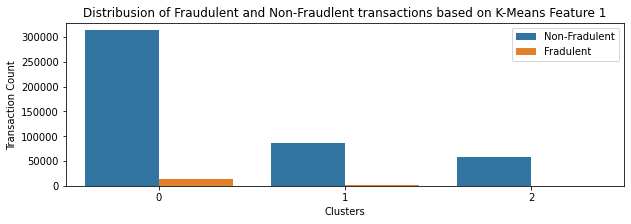

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,3))
sns.countplot(newTrain["clusterFeature1"], hue = newTrain["isFraud"])
plt.title("Distribusion of Fraudulent and Non-Fraudlent transactions based on K-Means Feature 1")
plt.legend(["Non-Fradulent", "Fradulent"])
plt.xlabel("Clusters")
plt.ylabel("Transaction Count")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Transaction Count')

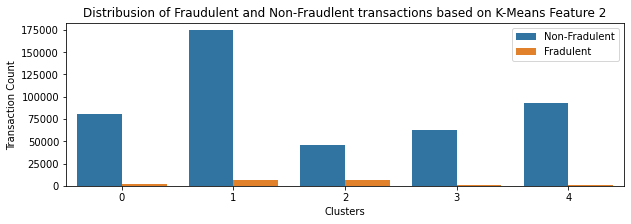

In [ ]:
plt.figure(figsize = (10,3))
sns.countplot(newTrain["clusterFeature2"], hue = newTrain["isFraud"])
plt.title("Distribusion of Fraudulent and Non-Fraudlent transactions based on K-Means Feature 2")
plt.legend(["Non-Fradulent", "Fradulent"])
plt.xlabel("Clusters")
plt.ylabel("Transaction Count")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Transaction Count')

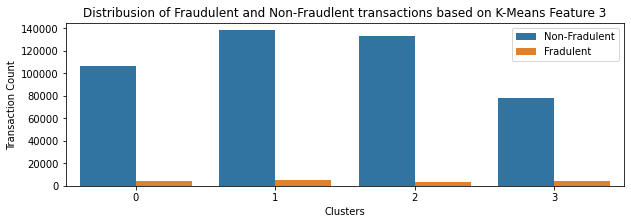

In [ ]:
plt.figure(figsize = (10,3))
sns.countplot(newTrain["clusterFeature3"], hue = newTrain["isFraud"])
plt.title("Distribusion of Fraudulent and Non-Fraudlent transactions based on K-Means Feature 3")
plt.legend(["Non-Fradulent", "Fradulent"])
plt.xlabel("Clusters")
plt.ylabel("Transaction Count")

In [ ]:
newTrain.shape, newValidation.shape

((472432, 146), (118108, 146))

# **Categorical Variables Encoding**

In [ ]:
cat_features =  ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M2', 'M3', 'M4', 'M6',
       'P_emaildomain_1', 'uid1', 'uid2', 'uid3', 'P_emaildomain_bin',
       'P_emaildomain_suffix']

target = ["isFraud"]

numeric_features = [x for x in newTrain.columns if x not in cat_features + target]

In [ ]:
#Target Encoding
for column in cat_features:
  mapper = newTrain[column].value_counts().to_dict()
  newTrain[column] = newTrain[column].map(mapper)
  newValidation[column] = newValidation[column].map(mapper)

# **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.3)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
newTrain_smote, y_smote = pipeline.fit_resample(newTrain.drop(["isFraud"], axis = 1), newTrain.isFraud)

In [ ]:
newTrain_smote["isFraud"] = y_smote

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


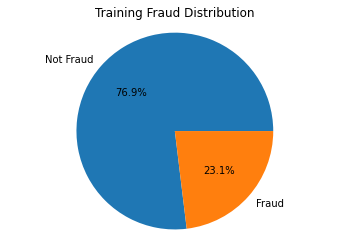

In [ ]:
# Class imbalance check
plt.pie(newTrain_smote["isFraud"].value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.title("Training Fraud Distribution")
plt.axis('equal')
plt.show()

In [ ]:
newTrain_smote.head()

,TransactionAmt,TransactionDT,card1,card2,card3,card5,addr1,addr2,C1,C2,...,uid3,Transaction_day_of_week,Transaction_hour_of_day,TransactionAmt_decimal,P_emaildomain_bin,P_emaildomain_suffix,clusterFeature1,clusterFeature2,clusterFeature3,isFraud
0,49.0,15810760.0,11204.0,298.0,150.0,226.0,272.0,87.0,1.0,2.0,...,244,6.0,23.0,0,258550,448741,0,0,3,0.0
1,33.5,3356017.0,8691.0,599.0,150.0,166.0,126.0,87.0,1.0,1.0,...,6,2.0,20.0,500,258550,448741,1,4,0,0.0
2,239.0,1877416.0,1214.0,523.0,150.0,226.0,126.0,87.0,1.0,1.0,...,11,6.0,17.0,0,258550,448741,1,1,3,0.0
3,24.0,12699373.0,1555.0,555.0,150.0,117.0,272.0,87.0,1.0,1.0,...,4,5.0,23.0,0,42141,20014,1,4,3,0.0
4,82.0,6816011.0,4030.0,174.0,150.0,226.0,126.0,87.0,2.0,1.0,...,571,0.0,21.0,0,258550,448741,1,4,0,0.0


In [ ]:
newTrain.shape, newTrain_smote.shape

((472432, 146), (197556, 146))

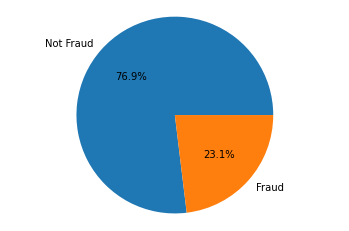

In [ ]:
# Class imbalance check
plt.pie(y_smote.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

# **Saving the Dataset**

In [ ]:
newTrain_smote = newTrain_smote.drop(["TransactionDT"], axis = 1)
newValidation = newValidation.drop(["TransactionDT"], axis = 1)

In [ ]:
newTrain_smote.to_csv(f"{data_path}FinalTrain.csv", index = False)
newValidation.to_csv(f"{data_path}FinalValidation.csv", index = False)